# Testing the Variable Projection method for Separable non-linear problems

@Author: Ettore Biondi - ebiondi@caltech.edu

In this notebook we are going to test and explore the variable projection method (Golub and Pereyra, 1973) on a simple exponential fitting problem. This kind of inverse problem falls into the set of separable non-linear problems; therefore, the variable-projection method (VarPro) can and should be applied. The analytical/modeling equation is represented by the following:
\begin{align}
y_{i} = a e^{-b t_{i}},
\end{align}
where $a$ and $b$ are the model parameters and $t_i$ indicates the $i$-th time sample. We are going to minimize the simple $L_{2}$ difference between the model and the observed data. Hence, we can write the objective function as the following:
\begin{align}
\phi(a,b) = \frac{1}{2} \|\mathbf{y}(a,b) - \mathbf{y}_{obs} \|_2^2.
\end{align}
We notice that this objective function is quadratic with respect to parameter $a$ and non-linear with respect to the other.

### Importing necessary libraries

In [1]:
import time
import numpy as np
import occamypy
#Plotting library
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# %matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':False
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


### Defining non-linear modeling operator for symultaneous inversion
Here we define the model vector as $\mathbf{m}= [a,b]^{T}$

In [2]:
class exponential_nl_sym(occamypy.Operator):

    def __init__(self, model, t_vec):
        """y(a,b;t) = a * exp(-b*t) """
        self.setDomainRange(model, t_vec)
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self, add, model, data):
        """Forward non-linear"""
        self.checkDomainRange(model, data)
        a = model[0]
        b = model[1]
        if not add: data.zero()
        data[:] += a * np.exp(-b*self.t_samples)
        return

class exponential_jac_sym(occamypy.Operator):

    def __init__(self, model, t_vec):
        """Jacobian matrix of the non-linear exponential for symultaneous inversion"""
        super(exponential_jac_sym, self).__init__(model, t_vec)
        self.m0 = model.clone()
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self, add, model, data):
        """Forward jacobian"""
        self.checkDomainRange(model, data)
        da = model[0]
        db = model[1]
        a0 = self.m0[0]
        b0 = self.m0[1]
        if not add: data.zero()
        data[:] += da * np.exp(-b0*self.t_samples) - a0 * self.t_samples * db * np.exp(-b0*self.t_samples)
        return

    def adjoint(self, add, model, data):
        """Adjoint jacobian"""
        self.checkDomainRange(model, data)
        da = model[0]
        db = model[1]
        a0 = self.m0[0]
        b0 = self.m0[1]
        if not add: model.zero()
        model[0] += np.sum(data[:] * np.exp(-b0*self.t_samples))
        model[1] -= np.sum(data[:] * a0 * self.t_samples*np.exp(-b0*self.t_samples))
        return

    def set_m0(self,m0):
        self.m0.copy(m0)
        return

In [3]:
#Generating observed data
time_vec = occamypy.VectorNumpy(np.linspace(0., 2., 200))
a_true = 10.0
b_true = 1.0
true_m = occamypy.VectorNumpy(np.array([a_true, b_true]))
modeling_op = exponential_nl_sym(true_m, time_vec)
data_true = time_vec.clone()
modeling_op.forward(False, true_m, data_true)

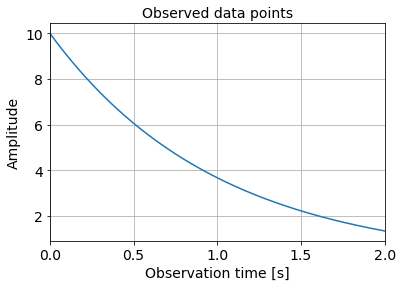

In [4]:
fig, ax = plt.subplots()
plt.plot(time_vec.plot(), data_true.plot())
plt.grid()
plt.title("Observed data points")
plt.xlabel("Observation time [s]")
plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)

In [5]:
# Generating Jacobian of the non-linear operator
modeling_op_jac = exponential_jac_sym(true_m, time_vec)
non_lin_op = occamypy.NonlinearOperator(modeling_op, modeling_op_jac, modeling_op_jac.set_m0)

# Instanciating non-linear problem
L2_sym = occamypy.NonlinearLeastSquares(true_m, data_true, non_lin_op)

In [6]:
#Computing the objective function for plotting
a_samples = np.linspace(0.0, 30.0, 500)
b_samples = np.linspace(-1.0, 6.0, 200)
obj_l2 = np.zeros((len(a_samples), len(b_samples)))

model_test = occamypy.VectorNumpy(np.array((0., 0.)))

for ia, a_value in enumerate(a_samples):
    for ib, b_value in enumerate(b_samples):
        model_test[0] = a_value
        model_test[1] = b_value
        obj_l2[ia, ib] = L2_sym.get_obj(model_test)

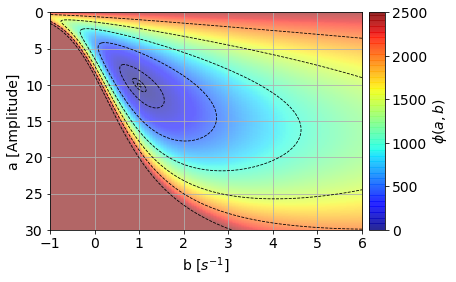

In [7]:
#Looking at the shape of the objective function
fig, ax = plt.subplots()
im = plt.imshow(obj_l2, vmin=0.0, vmax=2500, cmap='jet', extent=[-1., 6., 30., 0.], alpha=.6)
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black",
                 linewidths=(.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

In [8]:
niter = 1000
Stop  = occamypy.BasicStopper(niter=niter, tolr=1e-32, tolg=1e-32)
NLCGsolver = occamypy.NLCG(Stop, beta_type="FR")

model_init = model_test

a_initial = 2.0
b_initial = 0.0

model_init[0] = a_initial
model_init[1] = b_initial

# Setting initial model
_ = L2_sym.get_obj(model_init)
L2_sym.setDefaults()
NLCGsolver.setDefaults(save_obj=True, save_model=True)
t0 = time.time()

NLCGsolver.run(L2_sym, verbose=True)

print("Computational time %s s" % (time.time() - t0))

objNLCG = np.copy(NLCGsolver.obj)

# Converting sampled points to arrays for plotting
a_smpld = []
b_smpld = []
for i in range(len(NLCGsolver.model)):
    a_smpld.append(NLCGsolver.model[i][0])
    b_smpld.append(NLCGsolver.model[i][1])

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER 
	Restart folder: /tmp/restart_2021-02-17T17-42-12.781141/
	Conjugate method used: FR
##########################################################################################

iter = 0000, obj = 1.13543e+03, resnorm = 4.77e+01, gradnorm = 6.04e+02, feval = 1, geval = 1
iter = 0001, obj = 9.96829e+02, resnorm = 4.47e+01, gradnorm = 3.24e+02, feval = 4, geval = 2
iter = 0002, obj = 8.41188e+02, resnorm = 4.10e+01, gradnorm = 1.30e+03, feval = 7, geval = 3
iter = 0003, obj = 7.44506e+01, resnorm = 1.22e+01, gradnorm = 2.48e+02, feval = 10, geval = 4
iter = 0004, obj = 5.25159e+01, resnorm = 1.02e+01, gradnorm = 8.37e+01, feval = 13, geval = 5
iter = 0005, obj = 5.01772e+01, resnorm = 1.00e+01, gradnorm = 4.34e+01, feval = 16, geval = 6
iter = 0006, obj = 4.78102e+01, resnorm = 9.78e+00, gradnorm = 1.03e+02, feval = 19, geval = 7
iter = 0007, obj = 3.51325e+0

iter = 0157, obj = 7.03414e-17, resnorm = 1.19e-08, gradnorm = 7.82e-08, feval = 472, geval = 158
iter = 0158, obj = 6.68245e-17, resnorm = 1.16e-08, gradnorm = 1.73e-07, feval = 475, geval = 159
iter = 0159, obj = 5.02671e-17, resnorm = 1.00e-08, gradnorm = 3.33e-07, feval = 478, geval = 160
iter = 0160, obj = 2.21104e-17, resnorm = 6.65e-09, gradnorm = 2.90e-07, feval = 481, geval = 161
iter = 0161, obj = 1.11974e-17, resnorm = 4.73e-09, gradnorm = 1.29e-07, feval = 484, geval = 162
iter = 0162, obj = 9.35369e-18, resnorm = 4.33e-09, gradnorm = 5.03e-08, feval = 487, geval = 163
iter = 0163, obj = 9.06254e-18, resnorm = 4.26e-09, gradnorm = 2.38e-08, feval = 490, geval = 164
iter = 0164, obj = 8.96884e-18, resnorm = 4.24e-09, gradnorm = 2.08e-08, feval = 493, geval = 165
iter = 0165, obj = 8.79915e-18, resnorm = 4.20e-09, gradnorm = 3.68e-08, feval = 496, geval = 166
iter = 0166, obj = 7.95198e-18, resnorm = 3.99e-09, gradnorm = 8.35e-08, feval = 499, geval = 167
iter = 0167, obj = 4

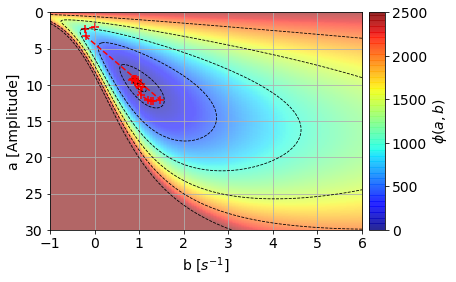

In [9]:
#Looking at the optimization path
fig, ax = plt.subplots()
plt.scatter(b_smpld ,a_smpld, color='red' ,s=50, marker="+")
plt.plot(b_smpld, a_smpld, "--", color='red')
im=plt.imshow(obj_l2, vmin=0., vmax=2500, cmap='jet', extent=[-1., 6., 30., 0.], alpha=.6)
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black",
                 linewidths=(.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

In [10]:
BFGSsolver = occamypy.LBFGS(Stop)

# Setting initial model
_ = L2_sym.get_obj(model_init)
L2_sym.setDefaults()
BFGSsolver.setDefaults(save_obj=True, save_model=True)
t0 = time.time()

BFGSsolver.run(L2_sym, verbose=True)
objBFGS = np.copy(BFGSsolver.obj)

print("Computational time %s s" % (time.time() - t0))

# Converting sampled points to arrays for plotting
a_smpld = []
b_smpld = []
for i in range(len(BFGSsolver.model)):
    a_smpld.append(BFGSsolver.model[i][0])
    b_smpld.append(BFGSsolver.model[i][1])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2021-02-17T17-42-13.545067/
##########################################################################################

iter = 0000, obj = 1.13543e+03, resnorm = 4.77e+01, gradnorm = 6.04e+02, feval = 1, geval = 1
iter = 0001, obj = 1.11043e+03, resnorm = 4.71e+01, gradnorm = 1.60e+03, feval = 2, geval = 2
iter = 0002, obj = 8.57238e+02, resnorm = 4.14e+01, gradnorm = 3.54e+02, feval = 3, geval = 3
iter = 0003, obj = 7.01722e+02, resnorm = 3.75e+01, gradnorm = 3.41e+02, feval = 4, geval = 4
iter = 0004, obj = 2.47522e+02, resnorm = 2.22e+01, gradnorm = 4.44e+02, feval = 5, geval = 5
iter = 0005, obj = 1.32921e+02, resnorm = 1.63e+01, gradnorm = 4.20e+02, feval = 6, geval = 6
iter = 0006, obj = 4.55506e+01, resnorm = 9.54e+00, gradnorm = 3.18e+02, feval = 7, geval = 7
iter = 0007, obj = 7.69313e+00, resnorm = 3.92e+00,

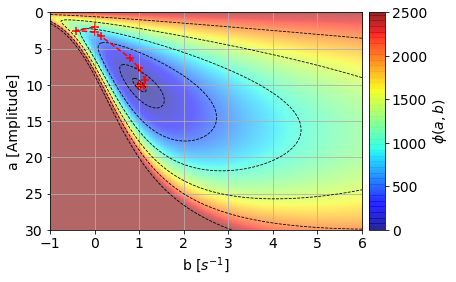

In [11]:
#Looking at the optimization path
fig, ax = plt.subplots()
plt.scatter(b_smpld, a_smpld, color='red', s=50, marker="+")
plt.plot(b_smpld, a_smpld, "--", color='red')
im = plt.imshow(obj_l2, vmin=0., vmax=2500, cmap='jet', extent=[-1., 6., 30., 0.], alpha=.6)
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black",
                 linewidths=(.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

Let's try to apply the VarPro method. Therefore, we reduce the number of model parameter to only $b$ because now $a$ is going to be function of $b$. In fact, we can write the new objective function as the following:
\begin{align}
\phi_{VarPro}(b) =  \frac{1}{2} \|\mathbf{y}(a_{opt}(b),b) - \mathbf{y}_{obs} \|_2^2,
\end{align}
where $a_{opt}(b)$ is given by:
\begin{align}
a_{opt}(b) = \frac{\exp(-b\mathbf{t})^{T}\mathbf{y}_{obs}}{\|\exp(-b\mathbf{t})\|_2^2},
\end{align}
which is the minimizer of the following quadratic problem for a fix $b$:
\begin{align}
\phi_{Lin}(a) =  \frac{1}{2} \|a \exp(-b\mathbf{t}) - \mathbf{y}_{obs} \|_2^2.
\end{align}

In [12]:
#Computing optimal a for each b
a_opt = []
t_samples = time_vec.getNdArray()

for ib, b_value in enumerate(b_samples):
    expb = np.exp(- b_value * t_samples)
    a_opt.append(np.dot(expb, data_true[:]) / np.dot(expb, expb))

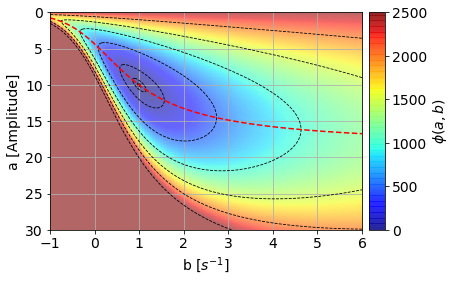

In [13]:
# Looking at the shape of the objective function and the curve along the optimal a
fig, ax = plt.subplots()
plt.plot(b_samples, a_opt, "--", color='red')
im = plt.imshow(obj_l2, vmin=0., vmax=2500, cmap='jet', extent=[-1., 6., 30., 0.], alpha=.6)
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black",
                 linewidths=(.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

In [14]:
# Computing the objective function along curve of the optimal a
obj_l2_vp = []
for ib, b_value in enumerate(b_samples):
    model_test[0] = a_opt[ib]
    model_test[1] = b_value
    obj_l2_vp.append(L2_sym.get_obj(model_test))

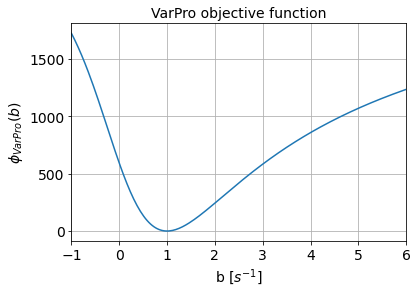

In [15]:
fig, ax = plt.subplots()
plt.plot(b_samples, obj_l2_vp)
plt.grid()
plt.title("VarPro objective function")
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("$\phi_{VarPro}(b)$")
ax.autoscale(enable=True, axis='x', tight=True)

Now let's solve the problem using the variable projection method. First, we need to create some operator to solve the linear problem when we fix the non-linear component of it.

In [16]:
class exponential_lin_op(occamypy.Operator):

    def __init__(self, model, t_vec):
        super(exponential_lin_op, self).__init__(model, t_vec)
        self.t_samples = t_vec.getNdArray()
        self.nl_model = model.clone()
        return

    def forward(self, add, model, data):
        """Forward jacobian"""
        self.checkDomainRange(model, data)
        b = self.nl_model[0]
        if not add: data.zero()
        data[:] += model[0] * np.exp( - b * self.t_samples)
        return

    def adjoint(self, add, model, data):
        """Adjoint jacobian"""
        self.checkDomainRange(model, data)
        b = self.nl_model[0]
        if not add: model.zero()
        model[0] += np.sum(data[:] * np.exp( - b * self.t_samples))
        return

    def set_nl(self, nl_model):
        """Function to set the non-linear component of the operator"""
        self.nl_model.copy(nl_model)
        return

Secondly, let's create the operator to solve the non-linear problem in the reduced space.

In [17]:
class exponential_nl_vp(occamypy.Operator):

    def __init__(self, model, t_vec):
        """y(a,b;t) = a * exp(-b*t) """
        super(exponential_nl_vp, self).__init__(model, t_vec)
        self.t_samples = t_vec.getNdArray()
        self.lin_model = model.clone()
        return

    def forward(self, add, model, data):
        """Forward non-linear"""
        self.checkDomainRange(model, data)
        a = self.lin_model[0]
        b = model[0]
        if not add: data.zero()
        data[:] += a * np.exp( - b * self.t_samples)
        return

    def set_lin(self, lin_model):
        """Function to set the linear component of the operator"""
        self.lin_model.copy(lin_model)
        return

class exponential_jac_vp(occamypy.Operator):

    def __init__(self, model, t_vec):
        """Jacobian matrix of the non-linear exponential for VarPro inversion"""
        super(exponential_jac_vp, self).__init__(model, t_vec)
        self.m0 = model.clone()
        self.lin_model = model.clone()
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self, add, model, data):
        """Forward jacobian"""
        self.checkDomainRange(model, data)
        db = model[0]
        a = self.lin_model[0]
        b0 = self.m0[0]
        if not add: data.zero()
        data[:] += - a * self.t_samples * db * np.exp( - b0 * self.t_samples)
        return

    def adjoint(self, add, model, data):
        """Adjoint jacobian"""
        self.checkDomainRange(model, data)
        a = self.lin_model[0]
        b0 = self.m0[0]
        if not add: model.zero()
        model[0] -= np.sum(data[:] * a * self.t_samples * np.exp( - b0 * self.t_samples))
        return

    def set_m0(self, m0):
        self.m0.copy(m0)
        return

    def set_lin(self, lin_model):
        """Function to set the linear component of the operator"""
        self.lin_model.copy(lin_model)
        return

In [18]:
a_init = occamypy.VectorNumpy(np.array([a_initial]))
b_init = occamypy.VectorNumpy(np.array([b_initial]))

# Creating non-linear operator
expon_nl = exponential_nl_vp(b_init, time_vec)
expon_nl.set_lin(a_init)

# Creating VP operator
expon_nl_jac = exponential_jac_vp(b_init, time_vec)
exp_nl_op = occamypy.NonlinearOperator(expon_nl, expon_nl_jac, expon_nl_jac.set_m0)
expon_lin = exponential_lin_op(a_init, time_vec)
exp_vp_op = occamypy.VarProOperator(exp_nl_op, expon_lin, expon_lin.set_nl, expon_nl_jac.set_lin,
                                    set_lin=expon_nl.set_lin)

# Instantiating VarPro problem object
VPproblem = occamypy.VarProRegularized(b_init, a_init, exp_vp_op, data_true,
                                       lin_solver=occamypy.CG(occamypy.BasicStopper(niter=10)))

In [19]:
BFGSsolver.setDefaults(save_obj=True, save_model=True)
t0 = time.time()
BFGSsolver.run(VPproblem, verbose=True)
objVPBFGS = np.copy(BFGSsolver.obj)
print("Computational time %s s" % (time.time() - t0))

# Converting sampled points to arrays for plotting
b_smpld = []
for i in range(len(BFGSsolver.model)):
    b_smpld.append(BFGSsolver.model[i][0])

##########################################################################################
Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm 
Restart folder: /tmp/restart_2021-02-17T17-42-13.545067/
##########################################################################################

iter = 0000, obj = 5.92480e+02, resnorm = 3.44e+01, gradnorm = 1.18e+03, feval = 1, geval = 1
iter = 0001, obj = 3.29176e+01, resnorm = 8.11e+00, gradnorm = 2.00e+02, feval = 8, geval = 8
iter = 0002, obj = 5.12584e+00, resnorm = 3.20e+00, gradnorm = 8.84e+01, feval = 9, geval = 9
iter = 0003, obj = 5.71224e-01, resnorm = 1.07e+00, gradnorm = 3.20e+01, feval = 10, geval = 10
iter = 0004, obj = 5.02185e-03, resnorm = 1.00e-01, gradnorm = 2.94e+00, feval = 11, geval = 11
iter = 0005, obj = 4.00045e-06, resnorm = 2.83e-03, gradnorm = 8.31e-02, feval = 12, geval = 12
iter = 0006, obj = 3.00748e-11, resnorm = 7.76e-06, gradnorm = 2.28e-04, feval = 13, geval = 13
iter = 0007, obj = 1.78904e-19, resnorm = 5

In [20]:
#Computing corresponding optimal a
a_smpld = []
t_samples = time_vec.getNdArray()

for ib, b_value in enumerate(b_smpld):
    expb = np.exp( - b_value * t_samples)
    a_smpld.append(np.dot(expb, data_true[:]) / np.dot(expb, expb))

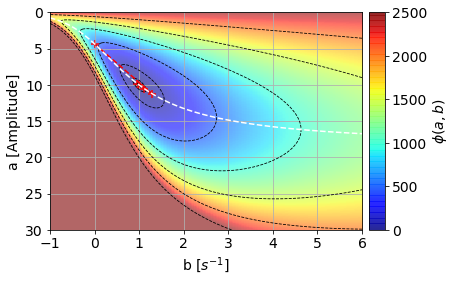

In [21]:
#Looking at the optimization path
fig, ax = plt.subplots()
plt.scatter(b_smpld, a_smpld, color='red', s=80, marker="+")
plt.plot(b_smpld, a_smpld, "--", color='red')
plt.plot(b_samples, a_opt, "--", color='white')
im=plt.imshow(obj_l2, vmin=0., vmax=2500, cmap='jet', extent=[-1., 6., 30., 0.], alpha=.6)
plt.xlabel("b [$s^{-1}$]")
plt.ylabel("a [Amplitude]")
plt.grid()
cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black",
                 linewidths=(.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=.1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('$\phi(a,b)$')
ax.set_aspect('auto')

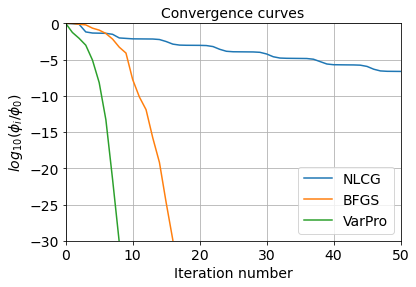

In [22]:
#Plotting convergence curves
fig, ax = plt.subplots()
plt.plot(range(len(objNLCG)),   np.log10(objNLCG   / objNLCG[0]   + 1e-40), label='NLCG')
plt.plot(range(len(objBFGS)),   np.log10(objBFGS   / objBFGS[0]   + 1e-40), label='BFGS')
plt.plot(range(len(objVPBFGS)), np.log10(objVPBFGS / objVPBFGS[0] + 1e-40), label='VarPro')
plt.grid()
plt.title("Convergence curves")
plt.xlabel("Iteration number")
plt.ylabel("$log_{10}(\phi_i/\phi_0)$")
ax.legend()
plt.xlim(0, 50)
plt.ylim(-30, 0)
plt.show()

### Solving the same problem with SciPy optimize

Let's now solve the same problem but using the Scipy Optimization module. Compared to SciPy, the modularity of Occamypy provides simple building blocks on which one can construct and solve large-scale optimization problems without too much effort. In this example, we solve a simple optimization problem. But, what if a complex operator formed by multiple functions has to be used to model the data? An example of such a problem, solved using Occamypy is the one described by Barnier et al. (2018) [https://library.seg.org/doi/abs/10.1190/segam2018-2998613.1]. The Occamypy infrastructure allows to seamlessly scale vectors and operators on HPC facilities thanks to the Dask interface. Finally, one limitation of libraries such as SciPy is their inability to handle large-scale vectors (e.g., 1 Tb of data) since they assume the possibility of storing and performing all vector operations in-core fashion. The Occamypy design allows performing all vector/operator computations regardless of the chosen computational paradigm (e.g., local, distributed, in-core, out-of-core).

In [23]:
from scipy.optimize import minimize
        
def objf(x , *args):
    """Objective-function evaluation"""
    temp_data = np.zeros_like(args[1])
    temp_data[:] = x[0] * np.exp(-x[1]*args[1])
    res = temp_data - args[0]
    obj = 0.5 * np.dot(res, res)
    return obj

def der(x, *args):
    """Function to compute objective-function derivative"""
    temp_data = np.zeros_like(args[1])
    tmp_exp = np.exp(-x[1]*args[1])
    temp_data[:] = x[0] * tmp_exp
    res = temp_data - args[0] 
    der = np.zeros_like(x)
    # Computing derivative with respect a and b parameters
    der[0] = np.sum(tmp_exp * res[:])
    der[1] = - np.sum(x[0] * args[1]*tmp_exp * res[:])
    return der

In [24]:
# Let's start by generating the observed data
time_samples = np.linspace(0., 2., 200)
a_true = 10.0
b_true = 1.0
x_true = np.array([a_true, b_true])
data_obs = x_true[0] * np.exp(-x_true[1]*time_samples)

In [25]:
# Now let's create the simple object containing the definition of the inverse problem
x0 = np.array([2.0, 0.0])
res = minimize(objf, x0, args=(data_obs, time_samples), method='BFGS', jac=der, options={'disp': True})
print("a_opt = ", res.x[0])
print("b_opt = ", res.x[1])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 13
         Gradient evaluations: 13
a_opt =  10.000000003720508
b_opt =  1.000000000489844


Let's now solve it using the VarPro method.

In [26]:
# Definition of the linear component of the problem (i.e., a parameter)
def objf_lin(x , *args):
    """Objective-function evaluation (linear parameter)"""
    data = args[0]
    t_samples = args[1]
    b = args[2]
    temp_data = np.zeros_like(t_samples)
    temp_data[:] = x[0] * np.exp(-b*t_samples)
    res = temp_data - data
    obj = 0.5 * np.dot(res, res)
    return obj

def der_lin(x, *args):
    """Function to compute objective-function derivative (linear parameter)"""
    data = args[0]
    t_samples = args[1]
    b = args[2]
    temp_data = np.zeros_like(args[1])
    tmp_exp = np.exp(-b*args[1])
    temp_data[:] = x[0] * tmp_exp
    res = temp_data - data
    der = np.zeros_like(x)
    # Computing derivative with respect a and b parameters
    der[0] = np.sum(tmp_exp * res[:])
    return der

# Definition of the non-linear component of the problem (i.e., b parameter)
def objf_VP(x , *args):
    """Objective-function evaluation using the VarPro method"""
    data = args[0]
    t_samples = args[1]
    temp_data = np.zeros_like(t_samples)
    b = x[0]
    # Solving linear problem for a fixed b = x[0]
    # a_opt = 
    temp_data[:] = x[0] * np.exp(-a_opt*t_samples)
    res = temp_data - args[0]
    obj = 0.5 * np.dot(res, res)
    return obj

def der_VP(x, *args):
    """Function to compute objective-function derivative"""
    temp_data = np.zeros_like(args[1])
    tmp_exp = np.exp(-x[1]*args[1])
    temp_data[:] = x[0] * tmp_exp
    res = temp_data - args[0] 
    der = np.zeros_like(x)
    # Computing derivative with respect a and b parameters
    der[0] = np.sum(tmp_exp * res[:])
    der[1] = - np.sum(x[0] * args[1]*tmp_exp * res[:])
    return der